# 기본 분류: 의류 이미지 분류
https://www.tensorflow.org/tutorials/keras/classification?hl=ko


옷 이미지를 분류하는 신경망 모델을 훈련 - `TensorFlow`, `tf.keras` 사용

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.12.0


## Import Fashion MNIST Dataset

- 10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 **패션 MNIST 데이터셋** 사용
- 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냄

<table>
  <tr><td>     <img src="https://tensorflow.org/images/fashion-mnist-sprite.png" alt="Fashion MNIST sprite" width="600">   </td></tr> 
</table>

- 패션 MNIST는 컴퓨터 비전 분야의 MNIST 데이터셋을 대신해서 자주 사용됨
  - MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있음
  - 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용, 코드를 테스트하고 디버깅하는 용도로 좋음

60,000개의 이미지를 사용하여 네트워크를 훈련하고 10,000개의 이미지를 사용하여 네트워크에서 이미지 분류를 학습한 정도를 평가 

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환 : 

- `train_images`와 `train_labels` 배열은 모델 학습에 사용되는 **훈련 세트**
- `test_images`와 `test_labels` 배열은 모델 테스트에 사용되는 **테스트 세트**

이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이 값을 가짐. 

`레이블(label)`은 0에서 9까지의 정수 배열로 이미지에 있는 옷의 *클래스*(class)를 나타냄

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑
- 데이터셋에 *클래스 이름*이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## EDA
- 훈련 세트 : 60,000개의 이미지, 각 이미지는 28x28 픽셀로 표현

In [3]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels) # 60000개의 레이블

60000

In [6]:
train_labels # 0~9 사이의 정수

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

- 테스트 세트 : 10,000개의 이미지, 28x28 픽셀

In [8]:
test_images.shape

(10000, 28, 28)

In [9]:
len(test_labels) # 10000개의 이미지에 대한 레이블

10000

## 데이터 전처리

훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있다.

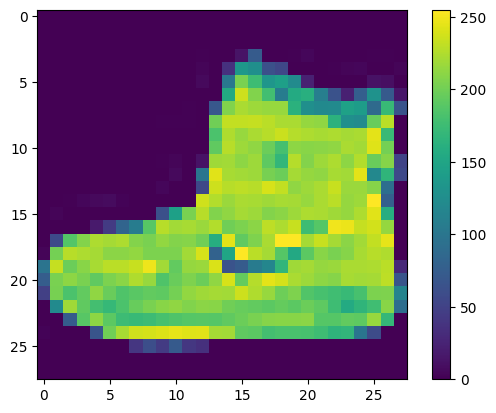

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

값의 범위를 0~1 사이로 조정
- *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요

In [11]:
train_images = train_images / 255.0

test_images = test_images / 255.0

*훈련 세트*에서 처음 25개 이미지와 그 아래 클래스 이름을 출력

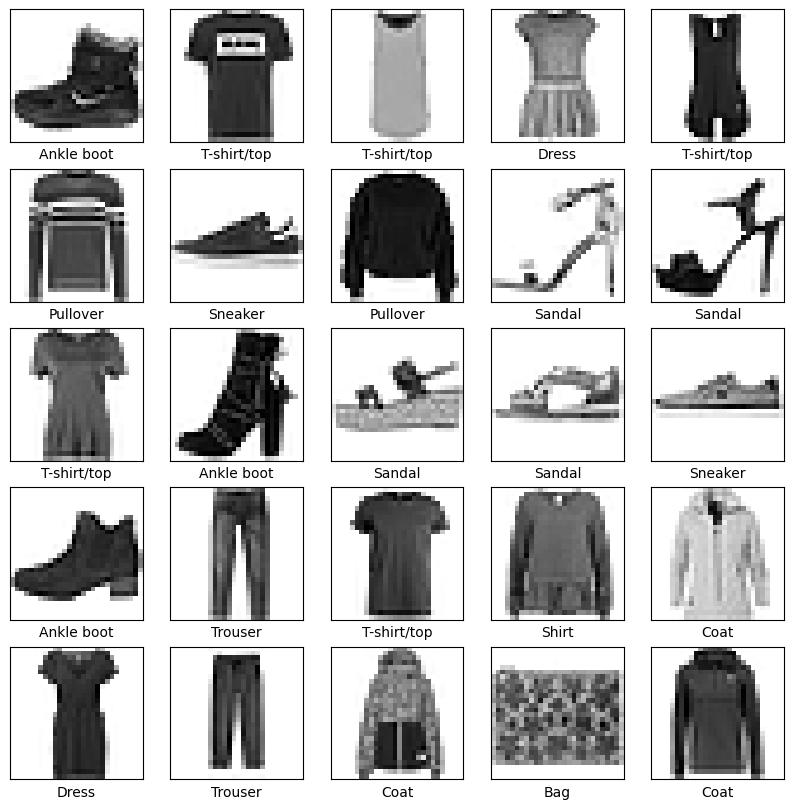

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## 모델 구성

모델의 층을 구성한 다음 컴파일

### 층 설정

레이어 : 신경망의 기본 빌딩 블록
- 레이어는 레이어에 공급된 데이터로부터 표현을 추출

대부분 딥러닝은 간단한 층을 연결하여 구성, `tf.keras.layers.Dense`와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됨

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

첫 번째 층 - `tf.keras.layers.Flatten`
- 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환
- 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘림
- 학습되는 가중치가 없고 데이터를 변환하기만 한다.

두 개의 `tf.keras.layers.Dense` 층이 연속되어 연결
- 밀집 연결(densely-connected) 또는 완전 연결(fully-connected)층이라고 함
- 첫 번째 `Dense` 층은 128개의 노드(또는 뉴런)를 가짐
- 두 번째 (마지막) 층은 10개의 노드의 *소프트맥스*(softmax) 층
  - 10개의 확률을 반환하고 반환된 값의 전체 합은 1
  - 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력



### 모델 컴파일

모델의 [*컴파일*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) 단계

- [*손실 함수*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) - 훈련 중 모델이 얼마나 정확한지 측정, 모델을 올바른 방향으로 조정하려면 이 함수를 최소화
- [*옵티마이저*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) - 모델이 인식하는 데이터와 해당 손실 함수를 기반으로 모델이 업데이트되는 방식
- [*메트릭*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) — 훈련 및 테스트 단계를 모니터링하는 데 사용, 다음 예에서는 올바르게 분류된 이미지의 비율인 *정확도*를 사용

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 모델 훈련

1. 훈련 데이터를 모델에 주입 - 이 예에서는 `train_images`와 `train_labels` 배열
2. 모델이 이미지와 레이블을 매핑하는 방법을 학습
3. 테스트 세트에 대한 모델의 예측을 만듬 - 이 예에서는 `test_images` 배열, 이 예측이 `test_labels` 배열의 레이블과 맞는지 확인
4. 예측이 `test_labels` 배열의 레이블과 일치하는지 확인


### 모델 피드

훈련을 시작하려면 [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) 메서드를 호출
- 모델을 훈련 데이터에 "맞추기(fit)" 때문에 이렇게 불린다.

In [15]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.4975 - accuracy: 0.8258
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3775 - accuracy: 0.8641
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3344 - accuracy: 0.8778
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3144 - accuracy: 0.8849
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2955 - accuracy: 0.8914
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2800 - accuracy: 0.8965
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2685 - accuracy: 0.8995
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2572 - accuracy: 0.9047
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2472 - accuracy: 0.9080
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0

모델이 훈련되면서 손실과 정확도 지표가 출력됨
- 이 모델은 훈련 세트에서 약 0.88(88%) 정도의 정확도를 달성

### 정확도 평가


In [16]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3371 - accuracy: 0.8837 - 701ms/epoch - 2ms/step

Test accuracy: 0.8837000131607056


테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮다.
- 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 *과대적합*(overfitting) 때문
- 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상

### 예측하기

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행 할 수 있다. 

소프트맥스 레이어를 연결하여 [로짓](https://developers.google.com/machine-learning/glossary#logits)을 해석하기 쉬운 확률로 변환

In [17]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [18]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측

In [19]:
#첫번째 예측
predictions[0]

array([1.1263508e-06, 2.6789925e-08, 4.6879254e-08, 1.1736938e-08,
       2.9756424e-07, 1.7691297e-04, 5.8898172e-07, 1.8616566e-02,
       2.6402269e-08, 9.8120445e-01], dtype=float32)

- 이 예측은 10개의 숫자 배열로 나타난다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄.

In [20]:
#가장 높은 신뢰도를 가진 레이블
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클 부츠(`class_name[9]`)라고 가장 확신하고 있다.

In [21]:
#테스트 레이블 확인
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현

In [22]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### 예측 확인

훈련된 모델을 사용하여 일부 이미지에 대한 예측을 수행

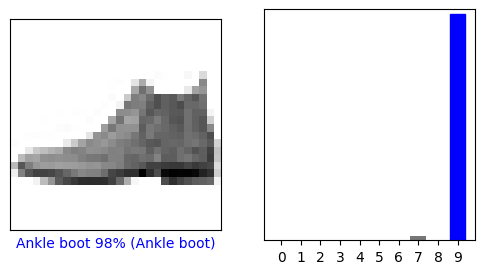

In [23]:
#0번째 원소의 이미지, 예측, 신뢰도 점수 배열 확인
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

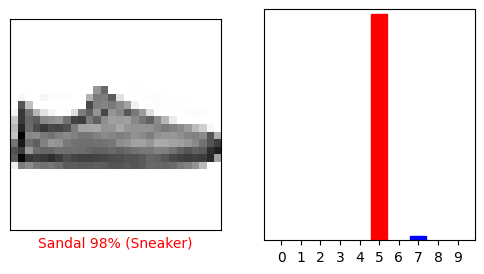

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

예측 출력 : 파란색 (O) , 빨강색 (X), 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)신뢰도 
- 점수가 높을 때도 잘못 예측할 수 있음

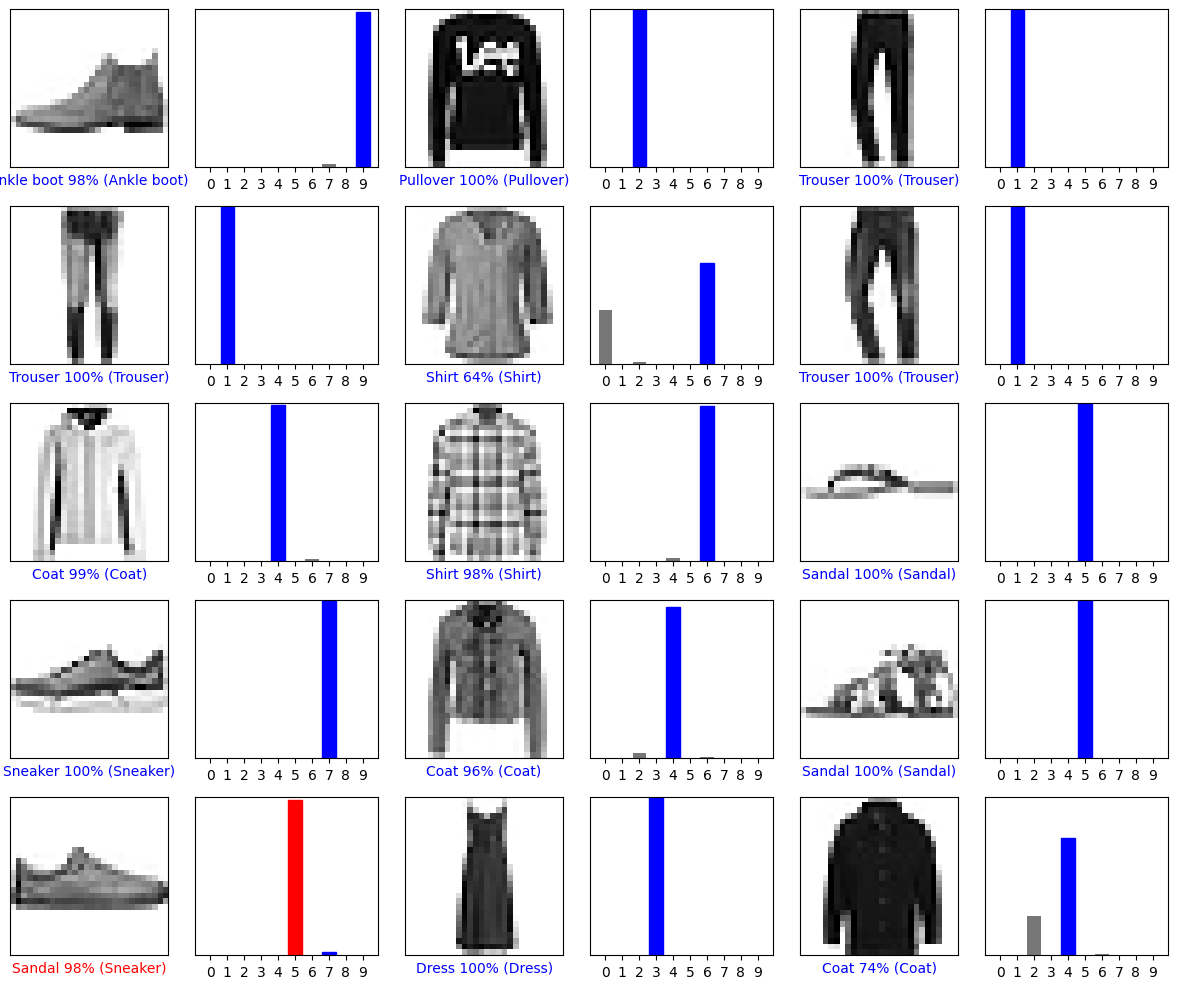

In [25]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 훈련된 모델 사용하기

훈련된 모델을 사용하여 한 이미지에 대한 예측을 만들기

In [26]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` 모델은 한 번에 샘플의 묶음 또는 *배치*(batch)로 예측을 만드는데 최적화되어 있음. 
- 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 한다.

In [27]:
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [28]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 46ms/step
[[3.00905162e-06 8.99371219e-16 9.99657393e-01 1.06445061e-11
  2.45569390e-04 1.09874796e-13 9.40788013e-05 8.91362721e-14
  4.96190502e-12 4.91439463e-13]]


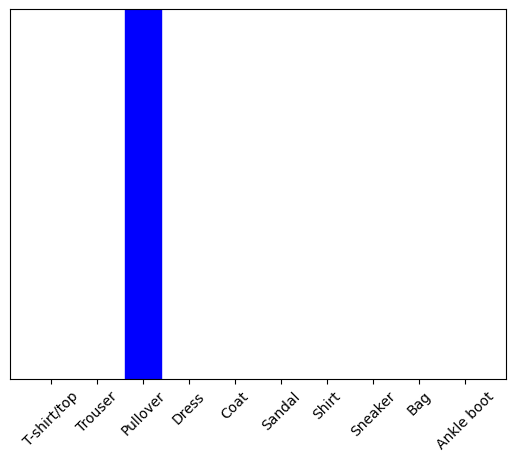

In [29]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict`는 데이터 배치의 각 이미지에 대해 하나의 목록씩 목록의 목록을 반환
- 배치에서 (유일한) 이미지에 대한 예측을 가져옴

In [30]:
np.argmax(predictions_single[0])

2